> This is a rework of my task during Computer Vision class in 2022.

> Goal(s):
- to demonstrate object detection in the Bag of Words (BoW) model, as instructed steps.

# Import Library

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import zipfile

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.vq import vq

# Image Preparation

In [2]:
def show_img(img, title, cmap=None):
  plt.imshow(img, cmap=cmap)
  plt.title(title)
  plt.axis('off')

In [3]:
path = 'dataset/object-detection/'
dataset_file_name = 'dogs-vs-cats.zip'

In [4]:
if not os.path.exists(path+dataset_file_name):
  !kaggle competitions download -c dogs-vs-cats
  os.rename(dataset_file_name, path+dataset_file_name)
  with zipfile.ZipFile(path+dataset_file_name, 'r') as zip_ref:
    zip_ref.extractall(path)
  with zipfile.ZipFile(path+'test1.zip', 'r') as zip_ref:
    zip_ref.extractall(path+'data/')
  with zipfile.ZipFile(path+'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path+'data/')

In [5]:
print('Total Train Dataset: ', len(os.listdir(path+'data/train/')))
print('Total Test Dataset: ', len(os.listdir(path+'data/test1/')))

Total Train Dataset:  25000
Total Test Dataset:  12500


> Due to the large size of the dataset, only 1000 of each available total dataset will be used.`

In [6]:
def compile_img(path, num_samples=None):
  images = []
  titles = []
  file_names = os.listdir(path)
  if num_samples:
    file_names = random.sample(file_names, num_samples)
  for file_name in file_names:
    img = cv2.cvtColor(cv2.imread(path + file_name), cv2.COLOR_BGR2RGB)
    images.append(img)
    titles.append(file_name)
  return images, titles

Visualization of 24 First Images of Train Dataset


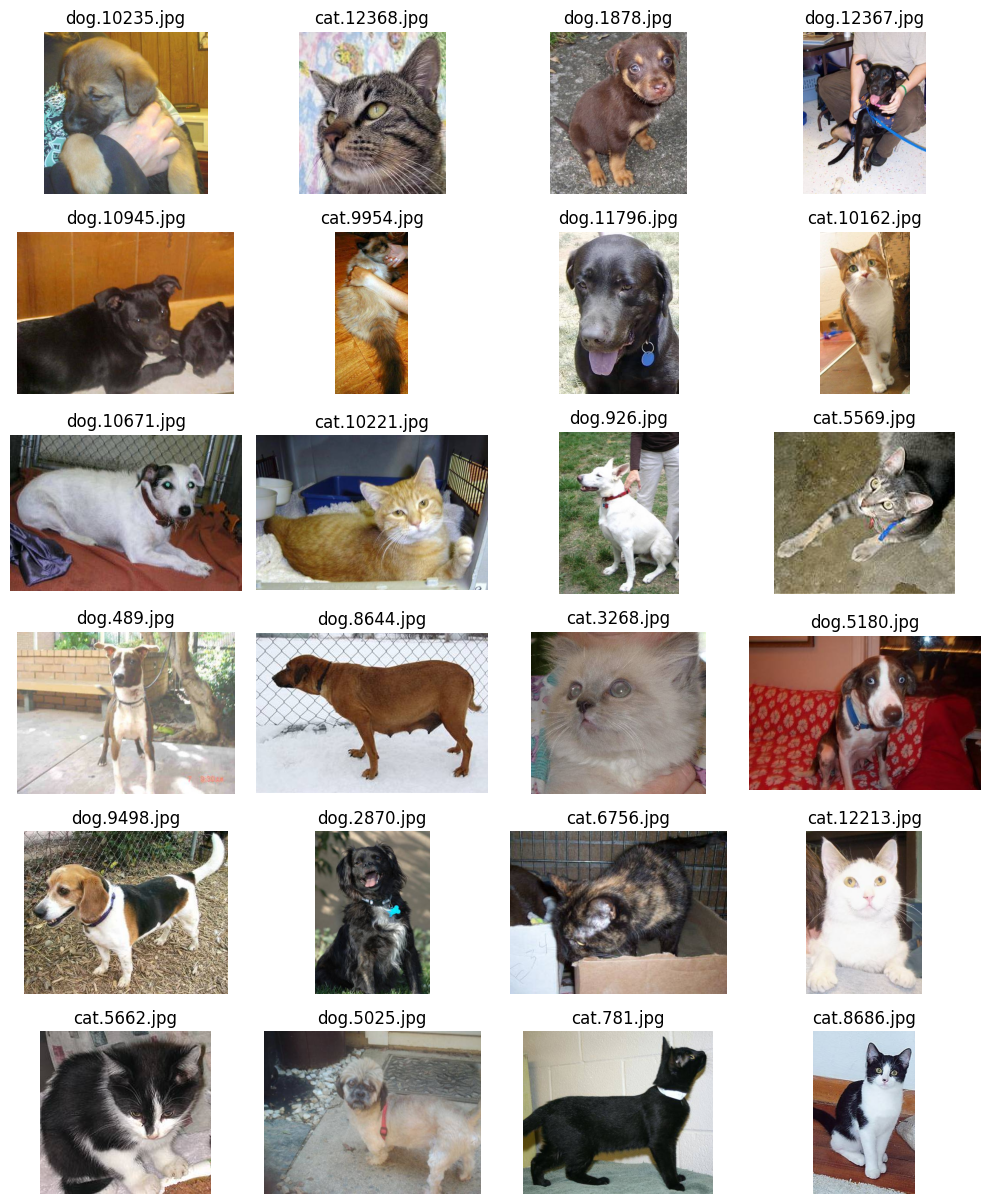

In [7]:
train_images, train_titles = compile_img(path+'data/train/', 1000)
num_rows = int(np.ceil(len(train_images) / 4))
print('Visualization of 24 First Images of Train Dataset')
plt.figure(figsize=(10, 2 * num_rows))
for idx, img in enumerate(train_images[:24]):
  plt.subplot(num_rows, 4, idx + 1)
  show_img(img, train_titles[idx])
plt.tight_layout()

In [8]:
train_labels = [title[:3] for title in train_titles]
print(np.unique(train_labels, return_counts=True))

(array(['cat', 'dog'], dtype='<U3'), array([504, 496], dtype=int64))


> The random samples gotten from the dataset are balanced.

Visualization of 24 First Images of Test Dataset


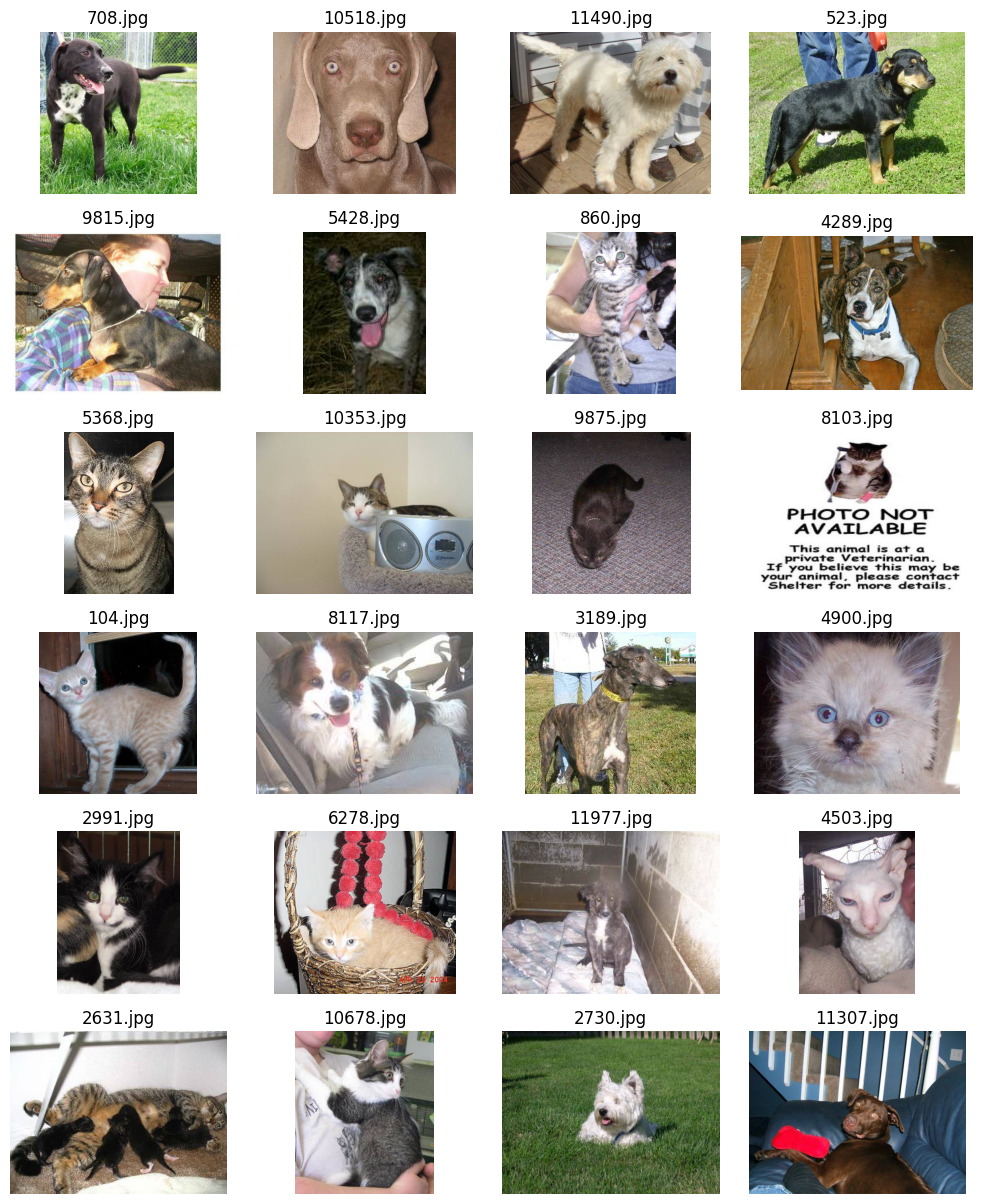

In [9]:
test_images, test_titles = compile_img(path+'data/test1/', 1000)
num_rows = int(np.ceil(len(test_images) / 4))
print('Visualization of 24 First Images of Test Dataset')
plt.figure(figsize=(10, 2 * num_rows))
for idx, img in enumerate(test_images[:24]):
  plt.subplot(num_rows, 4, idx + 1)
  show_img(img, test_titles[idx])
plt.tight_layout()

In [10]:
for idx, img in enumerate(train_images):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = cv2.GaussianBlur(img, (5, 5), 0)
  train_images[idx] = img

In [11]:
for idx, img in enumerate(test_images):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = cv2.GaussianBlur(img, (5, 5), 0)
  test_images[idx] = img

# Collect SIFT Descriptors from The Images

In [12]:
SIFT = cv2.SIFT_create()

In [13]:
def generate_SIFT(images):
  descriptors = []
  keypoints = []
  for img in images:
    keypoint, descriptor = SIFT.detectAndCompute(img, None)
    descriptor = descriptor.astype('f')
    descriptors.append(descriptor)
    keypoints.append(keypoint)
  return descriptors, keypoints

In [14]:
train_descriptors, _ = generate_SIFT(train_images)

In [15]:
def stack_descriptor(descriptors):
  stacked_desc = descriptors[0]
  for i in descriptors[1:]:
    stacked_desc = np.vstack((stacked_desc, i))
  stacked_desc = np.float32(stacked_desc)
  return stacked_desc

In [16]:
train_stacked_desc = stack_descriptor(train_descriptors)

# Clustering Descriptors using K Means

> The center of these clusters are the "visual words" which represent the key features in the database of images.

> Elbow Method can be used to determine the most optimal value for `K`. Every `K` (number of clusters) will be plotted with Within-Cluster Sum of Square (WCSS) which is obtained by calculating the sum of squared distance between each point and the centroid in a cluster.

In [17]:
def elbow_method_kmeans(descriptors, k_max, random_state=7):
  wcss = []
  for i in range(1, k_max + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=random_state)
    kmeans.fit(descriptors)
    wcss.append(kmeans.inertia_)

  plt.title('Number of K Values VS Inertia')
  plt.plot(np.arange(1, k_max + 1), wcss)
  plt.xlabel('K')
  plt.ylabel('Inertia')
  plt.show()

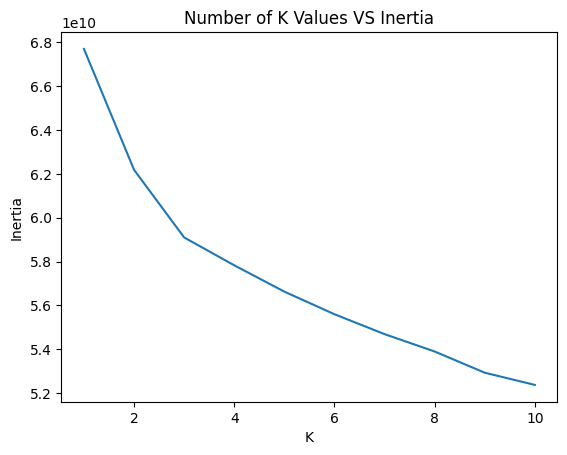

In [18]:
elbow_method_kmeans(train_stacked_desc, 10)

> By this graph, we can see that 3 is the `K` point where the decrease in inertia begins to slow. Hence, `K` = 3 is the "elbow" of this graph.

In [19]:
kmeans = KMeans(n_clusters=3, n_init=3)
kmeans.fit(train_stacked_desc)
centroids = kmeans.cluster_centers_

# Create The Vector V For Every Image

> To represent each image in the dataset, this step will initialize a K-dimensional vector where `K` is the number of features in the dictionary. Then, the closest cluster center for every image will be determined using Euclidean distance for each feature.

In [20]:
def create_vector_v(images, descriptors, centroids):
  v = np.zeros((len(images), len(centroids)), 'float32')
  for idx, descriptor in enumerate(descriptors):
    for feature in descriptor:
      clusters, _ = vq([feature], centroids)
      for cluster in clusters:
        v[idx][cluster] += 1
  return v

In [21]:
train_v = create_vector_v(train_images, train_descriptors, centroids)

In [22]:
print(f'Total Descriptor on The First Image: {train_descriptors[0].shape[0]}')
print(f'Total Descriptor on The First Cluster of The First Image: {int(train_v[0][0])}')

Total Descriptor on The First Image: 458
Total Descriptor on The First Cluster of The First Image: 168


> Each element of the K-dimensional vector for an image represents the number of descriptors assigned to a particular cluster. As example, the first image has a total of 690 descriptors and a total of 282 descriptors closest to the first cluster center.

# Normalize Vector V

> The objective of this step is to make images with very different number of SIFT key-points found can be made comparable.

In [23]:
def normalize_vector_v(v):
  norm_v = v.copy()
  norm_v /= v.sum()
  return norm_v

In [24]:
train_norm_v = normalize_vector_v(train_v)

# Applying K-NN to Detect The Object

## Preparing Test Dataset

In [25]:
test_descriptors, _ = generate_SIFT(test_images)

In [26]:
test_v = create_vector_v(test_images, test_descriptors, centroids)

In [27]:
test_norm_v = normalize_vector_v(test_v)

## Applying K-NN

In [28]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_norm_v, train_labels)

KNeighborsClassifier(n_neighbors=3)

In [29]:
result = knn.predict(test_norm_v)

Visualization of 24 First Images of Test Dataset and Its Predicted Labels


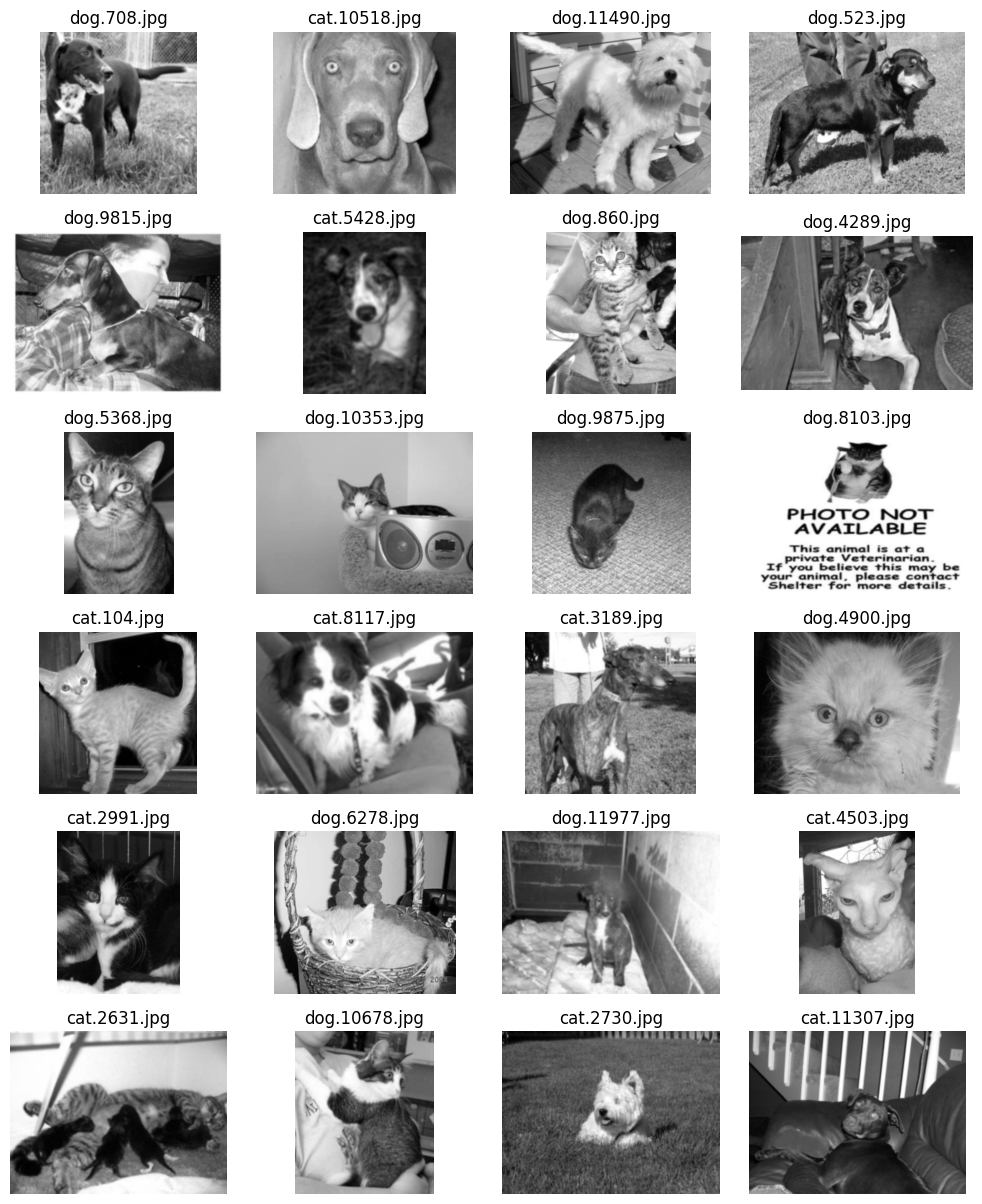

: 

In [30]:
print('Visualization of 24 First Images of Test Dataset and Its Predicted Labels')
plt.figure(figsize=(10, 2 * num_rows))
for idx, img in enumerate(test_images[:24]):
  plt.subplot(num_rows, 4, idx + 1)
  show_img(img, result[idx]+'.'+test_titles[idx], 'gray')
plt.tight_layout()

> Based on these results (24 out of 1000 total Testing Dataset), it can be concluded that the accuracy cannot be said to be good enough. Apart from the limited dataset that can be used (only 1000 of the total dataset, both for training and testing), this may also be due to the varied images (as examples, some images has people and other objects that are even larger than the cat or dog). Hence, this may not be the best result that can be obtained.